In [1]:
# !pip install -U segmentation-models-pytorch

In [2]:
# To fix module 'albumentations' has no attribute 'Lambda'
# !pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [3]:
# !pip install -U albumentations[imgaug]

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines)
{
    return false;
}

<IPython.core.display.Javascript object>

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [2]:
# !nvidia-smi
print('hi!')

hi!


In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set GPU-0 to use
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [5]:
# !git clone https://github.com/GeorgeSeif/Semantic-Segmentation-Suite.git

In [6]:
import os
from pathlib import Path

DATA_DIR = Path('CustomDataset')

(574, 1280, 3)

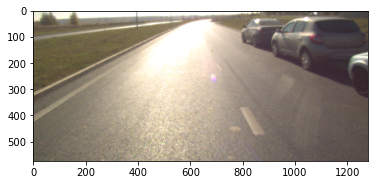

In [7]:
import numpy as np

img_name = '08_10_2021_15_55_45_702_crop.png'

img = cv2.imread(str(DATA_DIR) + f'/train/{img_name}')
img = cv2.cvtColor((img), cv2.COLOR_BGR2RGB)

plt.imshow(img)
img.shape

(574, 1280)

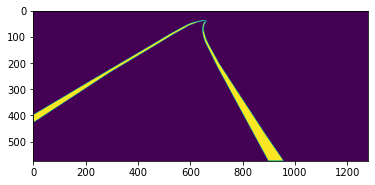

In [8]:
mask = cv2.imread(str(DATA_DIR) + f'/train_labels/{img_name}')
mask = cv2.cvtColor((mask).astype(np.uint8), cv2.COLOR_BGR2GRAY)

plt.imshow(mask)
mask.shape

In [9]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'valid')
y_valid_dir = os.path.join(DATA_DIR, 'valid_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [11]:
# Read img, apply augmentation and preprocessing transformation

# Augmentation (albumentations.Compose): data transfromation pipeline 
# Preprocessing (albumentations.Compose): data preprocessing 
#     (e.g. noralization, shape manipulation, etc.) 

class Dataset(BaseDataset):
 
    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None):
        self.ids = os.listdir(images_dir)
        self.mask_ids = os.listdir(masks_dir)

        self.images = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks = [os.path.join(masks_dir, image_id) for image_id in self.mask_ids]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks[i])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        image = cv2.resize(image, (640, 288))
        mask = cv2.resize(mask, (640, 288))
#         image = cv2.resize(image, (480, 384))
#         mask = cv2.resize(mask, (480, 384))

        mask = cv2.normalize(mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        mask = np.expand_dims(mask, axis=2)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

Reading time: 0.039919137954711914
(288, 640, 3) (288, 640, 1)


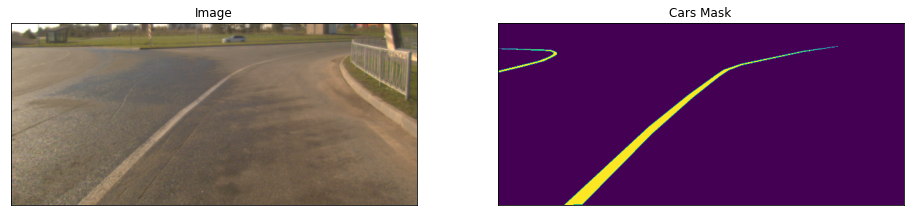

In [12]:
import time

dataset = Dataset(x_train_dir, y_train_dir)

start_time = time.time()
image, mask = dataset[6]
print(f'Reading time: {time.time() - start_time}')

print(image.shape, mask.shape)
visualize(image=image, cars_mask=mask.squeeze())

### Augmentations

In [13]:
import albumentations as albu

In [14]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
#         albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
#         albu.RandomCrop(height=320, width=320, always_apply=True),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #albu.PadIfNeeded(384, 480)
#         albu.RandomCrop(height=384, width=480, always_apply=True),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

(288, 640, 3) (288, 640, 1)


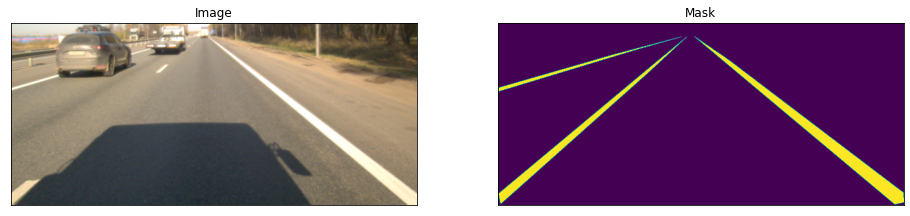

(288, 640, 3) (288, 640, 1)


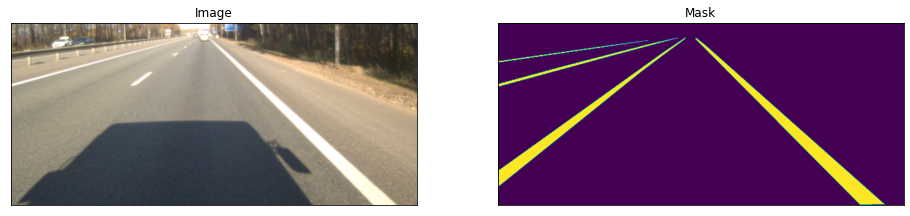

(288, 640, 3) (288, 640, 1)


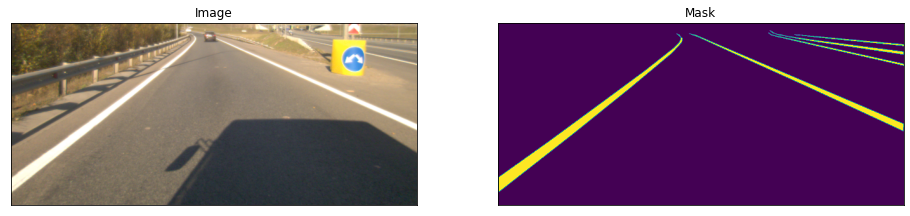

(288, 640, 3) (288, 640, 1)


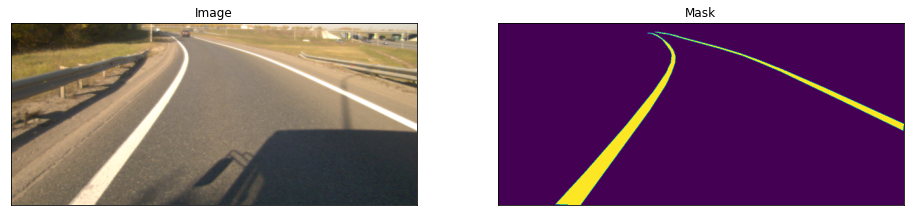

(288, 640, 3) (288, 640, 1)


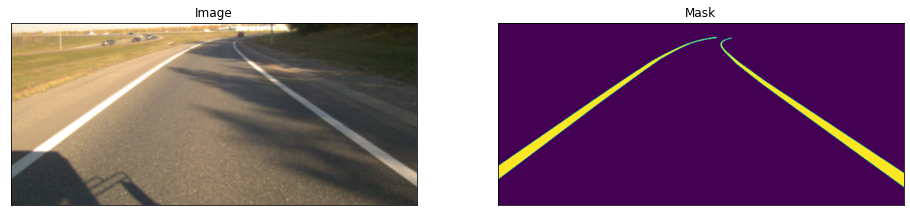

(288, 640, 3) (288, 640, 1)


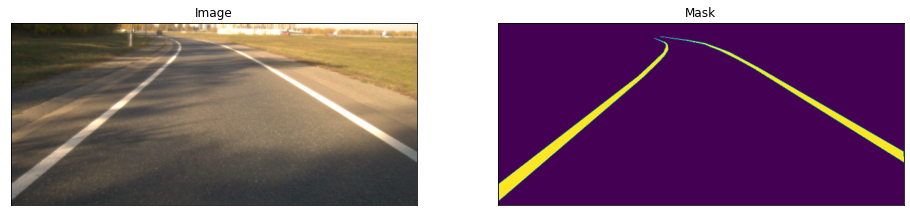

(288, 640, 3) (288, 640, 1)


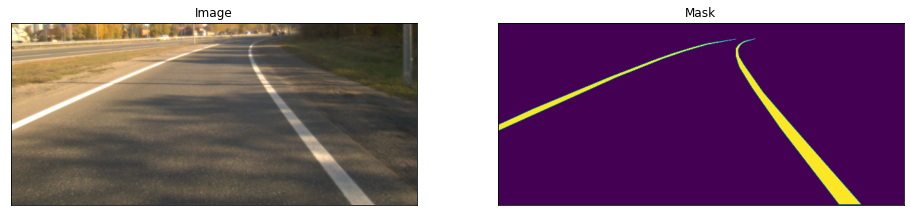

(288, 640, 3) (288, 640, 1)


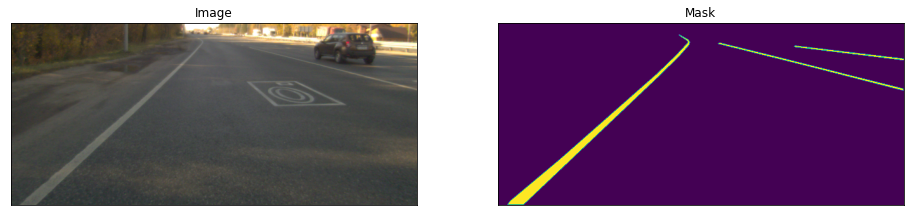

(288, 640, 3) (288, 640, 1)


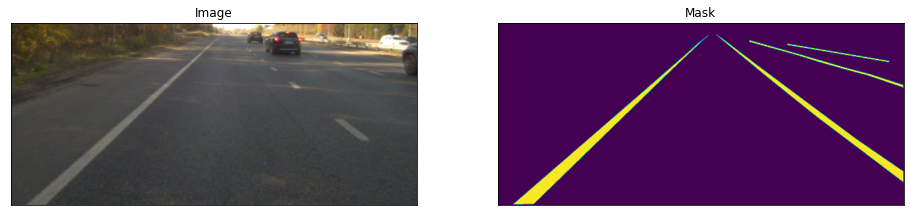

(288, 640, 3) (288, 640, 1)


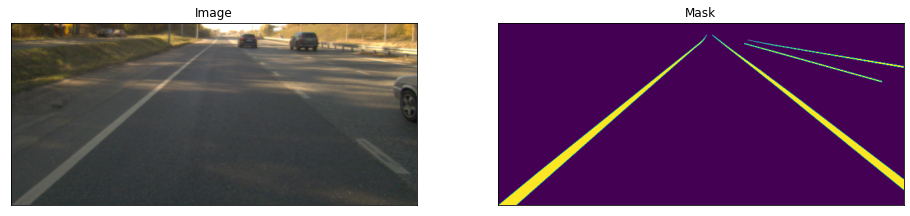

In [15]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(100, 110):
    image, mask = augmented_dataset[i]
    print(image.shape, mask.shape)

    visualize(image=image, mask=mask)

(288, 640, 3) (288, 640, 1)


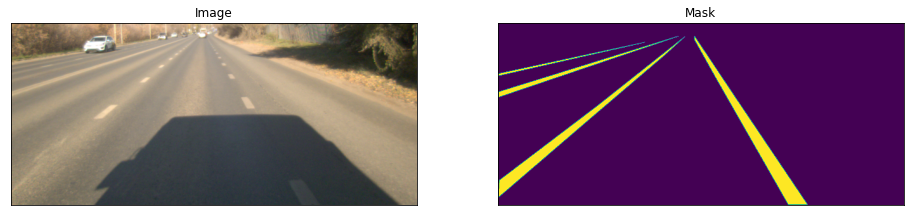

(288, 640, 3) (288, 640, 1)


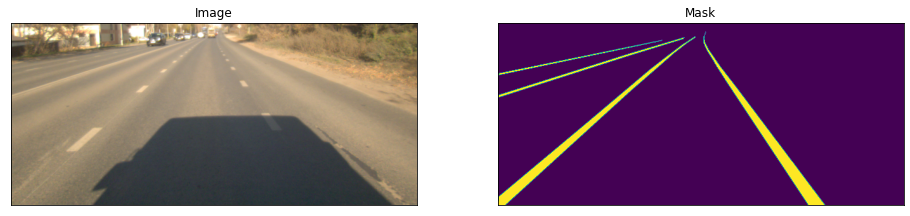

(288, 640, 3) (288, 640, 1)


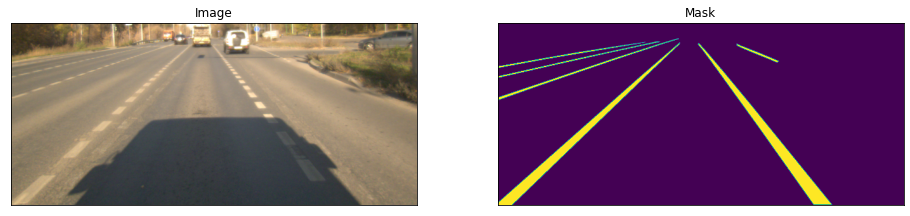

(288, 640, 3) (288, 640, 1)


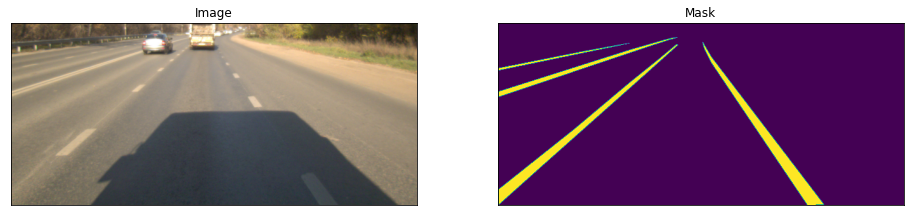

(288, 640, 3) (288, 640, 1)


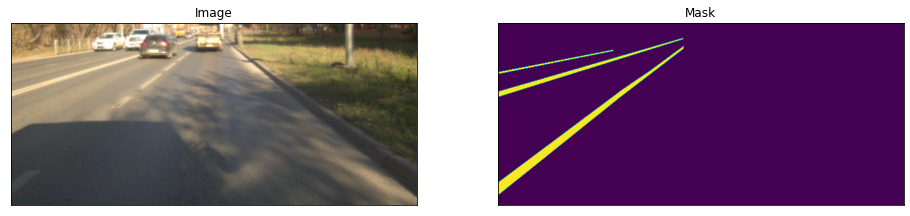

(288, 640, 3) (288, 640, 1)


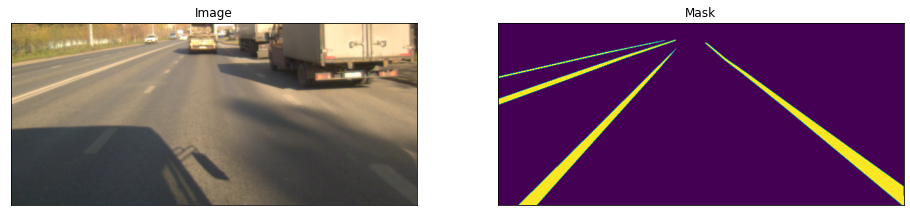

(288, 640, 3) (288, 640, 1)


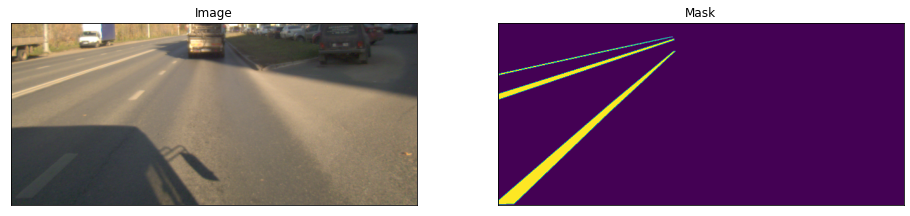

(288, 640, 3) (288, 640, 1)


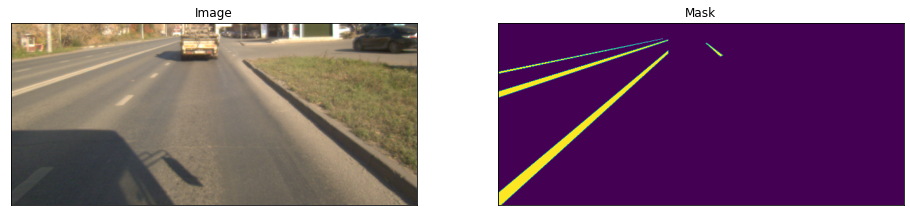

(288, 640, 3) (288, 640, 1)


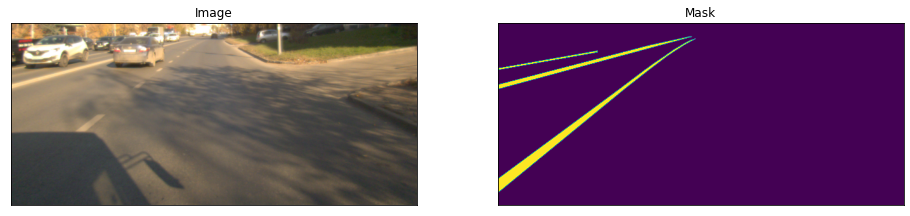

(288, 640, 3) (288, 640, 1)


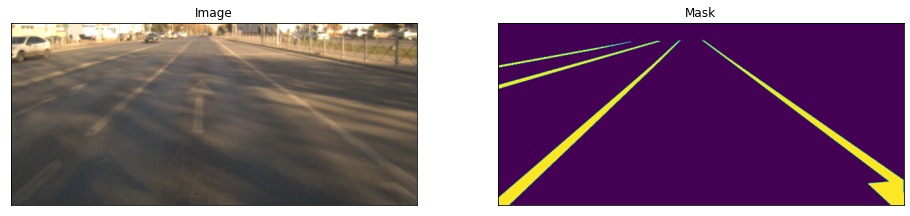

In [16]:
augmented_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation()
)

# same image with different random transforms
for i in range(100, 110):
    image, mask = augmented_dataset[i]
    print(image.shape, mask.shape)

    visualize(image=image, mask=mask)

## Create model and train

In [17]:
import wandb


wandb.init(
    project='lane_segmentation',
    entity='techtoker',
    config={
        "ENCODER": "se_resnext50_32x4d",
        'ENCODER_WEIGHTS': 'imagenet',
        "epoch": 30,
        "batch_size": 4,
        "lr":1e-4,
        "iou_threshold":0.5,
    })

config = wandb.config

wandb: Currently logged in as: techtoker (use `wandb login --relogin` to force relogin)


In [18]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [19]:
ENCODER = config['ENCODER']
ENCODER_WEIGHTS = config['ENCODER_WEIGHTS']

ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [20]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True)

In [21]:
# Get one sample from dataset; Check its size

inputs, classes = next(iter(train_loader))
print(f'Train: {inputs.size()}, {classes.size()}')

inputs, classes = next(iter(valid_loader))
print(f'Validation: {inputs.size()}, {classes.size()}')

Train: torch.Size([4, 3, 288, 640]), torch.Size([4, 1, 288, 640])
Validation: torch.Size([4, 3, 288, 640]), torch.Size([4, 1, 288, 640])


In [22]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=config['iou_threshold']),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=config['lr']),
])

In [23]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [42]:
# # Free cuda memory

# for i, left in enumerate(train_loader):
#     print(i)
#     with torch.no_grad():
#         temp = model(left).view(-1, 1, 300, 300)
#     right.append(temp.to('cpu'))
#     del temp
#     torch.cuda.empty_cache()

In [46]:
optimizer.param_groups[0]['lr'] = 1e-5

In [47]:
# train model for 40 epochs

max_score = 0

for i in range(0, config['epoch']):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    wandb.log({"train_iou_score": train_logs['iou_score'],
               "train_dice_loss": train_logs['dice_loss'],
               "valid_iou_score": valid_logs['iou_score'],
               "valid_dice_loss": valid_logs['dice_loss'] })
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['dice_loss']:
        max_score = valid_logs['dice_loss']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
#     if i == 25:
#         optimizer.param_groups[0]['lr'] = 1e-5
#         print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s, dice_loss - 0.07227, iou_score - 0.8666]
Model saved!

Epoch: 1
valid: 100%|████████████████████████████████| 100/100 [00:18<00:00,  5.55it/s, dice_loss - 0.07053, iou_score - 0.8696]

Epoch: 2
valid: 100%|████████████████████████████████| 100/100 [00:18<00:00,  5.52it/s, dice_loss - 0.06827, iou_score - 0.8735]

Epoch: 3
valid: 100%|████████████████████████████████| 100/100 [00:18<00:00,  5.51it/s, dice_loss - 0.06653, iou_score - 0.8766]

Epoch: 4
valid: 100%|████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s, dice_loss - 0.06513, iou_score - 0.8791]

Epoch: 5
valid: 100%|████████████████████████████████| 100/100 [00:18<00:00,  5.48it/s, dice_loss - 0.06455, iou_score - 0.8801]

Epoch: 6
train:   2%|▊                                 | 9/396 [00:02<02:00,  3.21it/s, dice_loss - 0.07021, iou_score - 0.8709]


KeyboardInterrupt: 

## Test best saved model

In [25]:
# torch.save(model, './best_model.pth')

In [54]:
torch.save(model, './best_model.pth')
print('Model saved!')

Model saved!


In [48]:
# load best saved checkpoint
# best_model = torch.load('./best_model.pth')
best_model = model

In [49]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

test_dataloader = DataLoader(test_dataset)

In [50]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|████████████████████████████████| 399/399 [00:23<00:00, 17.28it/s, dice_loss - 0.06677, iou_score - 0.8775]


## Visualize predictions

In [51]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
)

In [52]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(24, 8))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

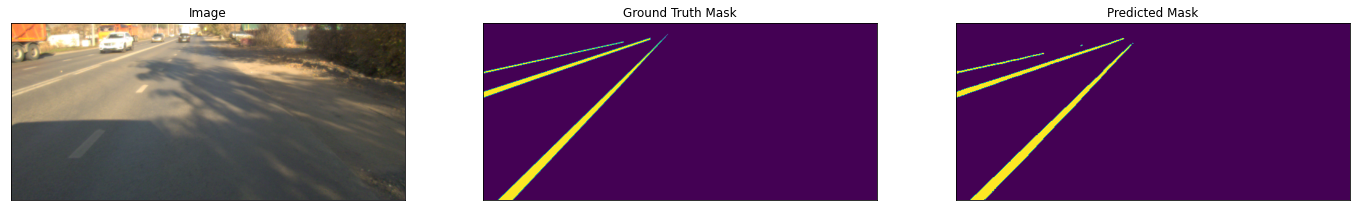

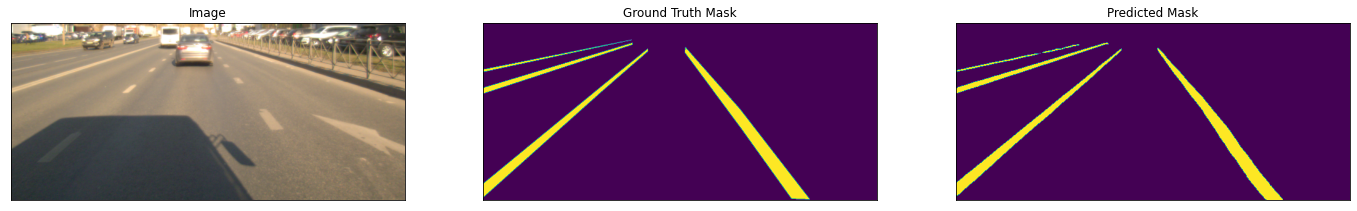

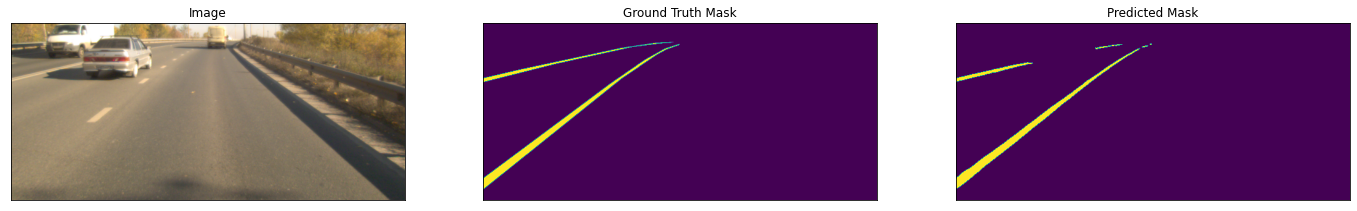

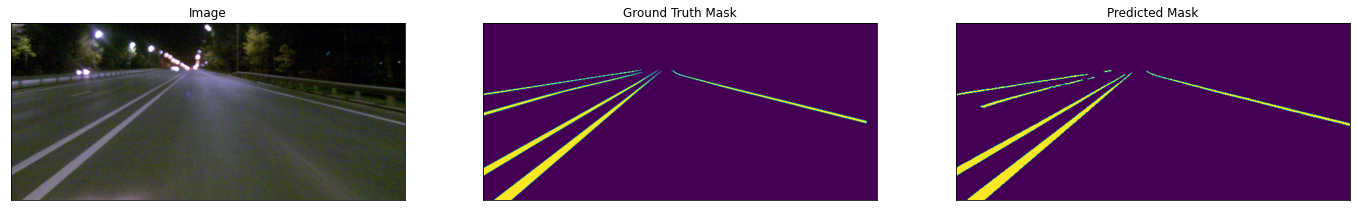

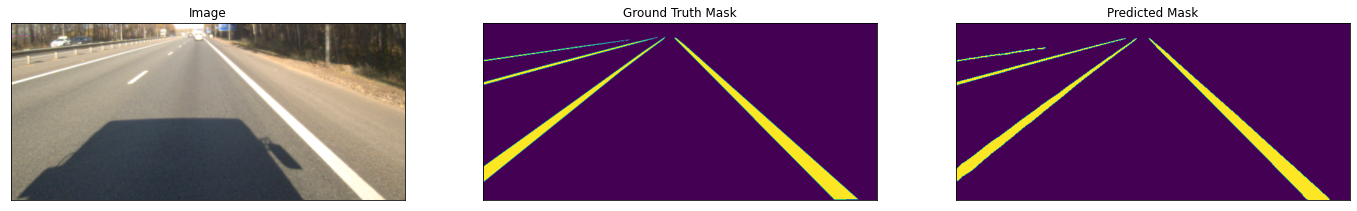

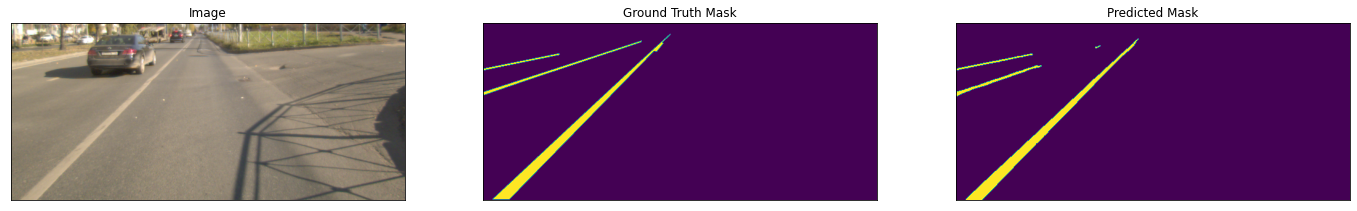

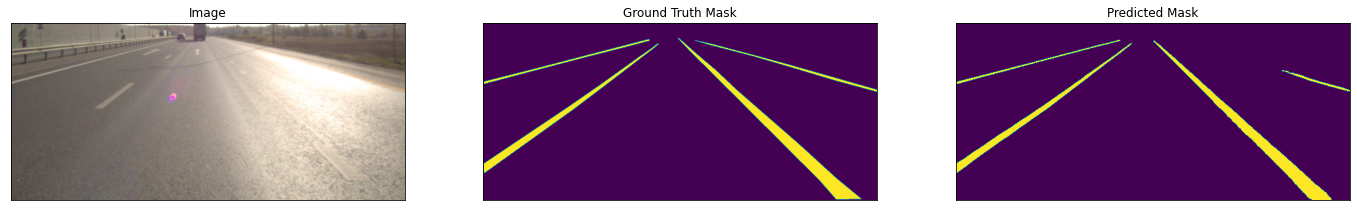

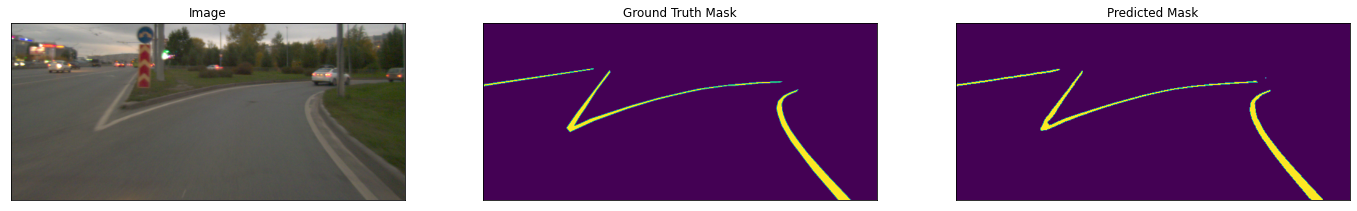

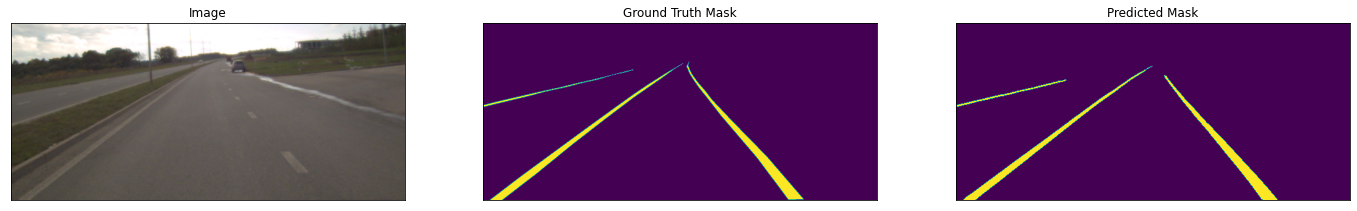

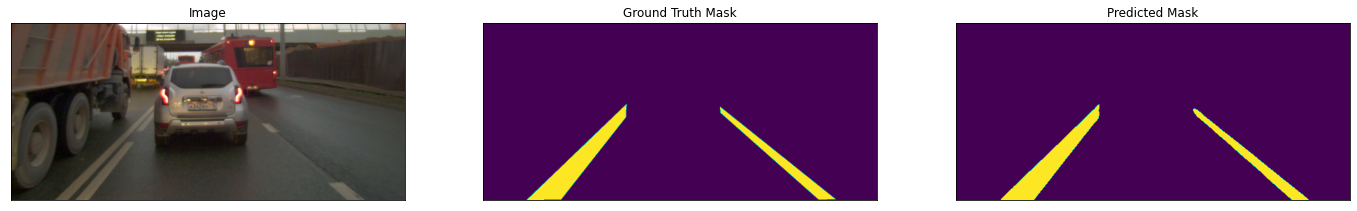

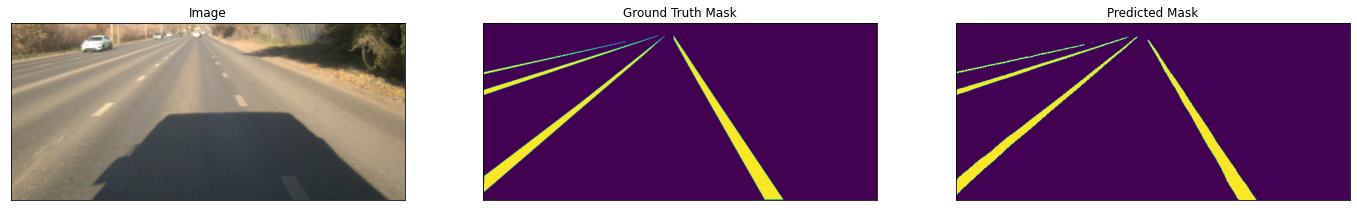

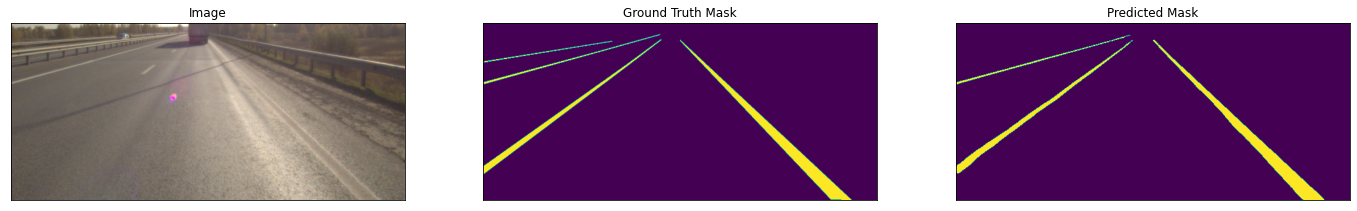

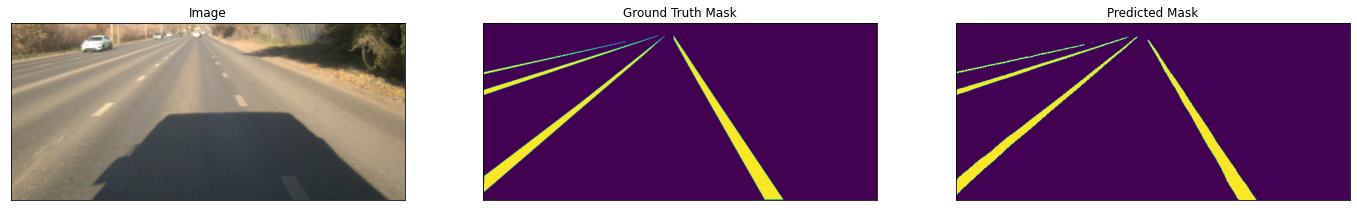

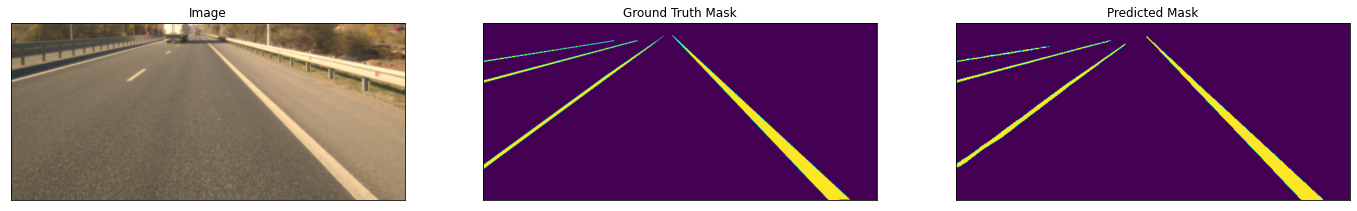

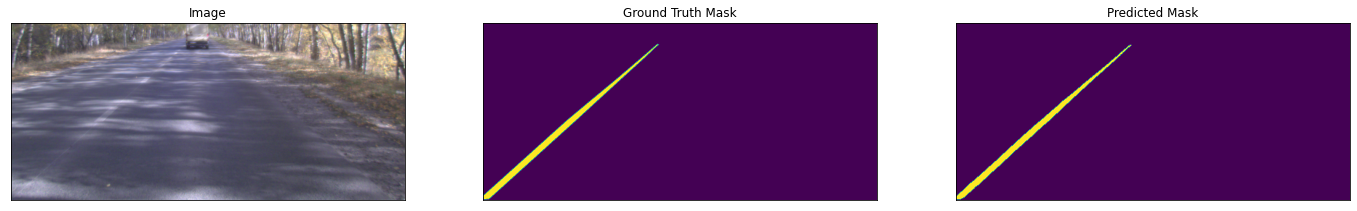

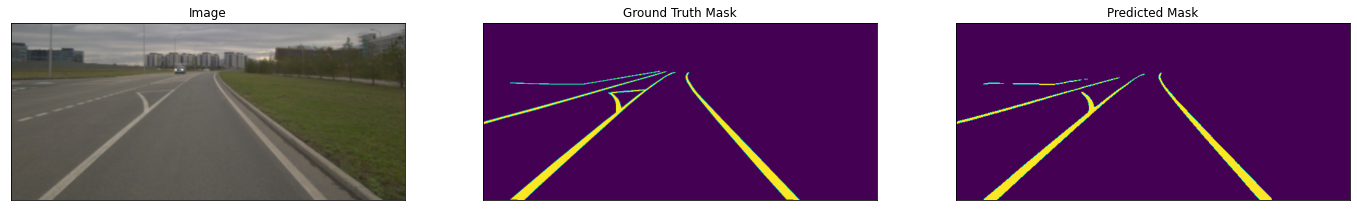

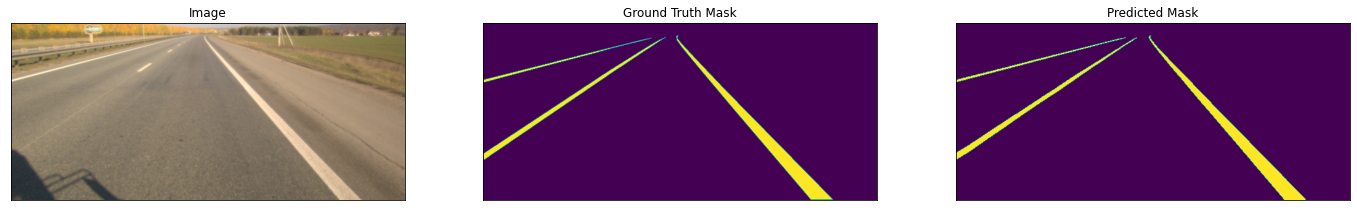

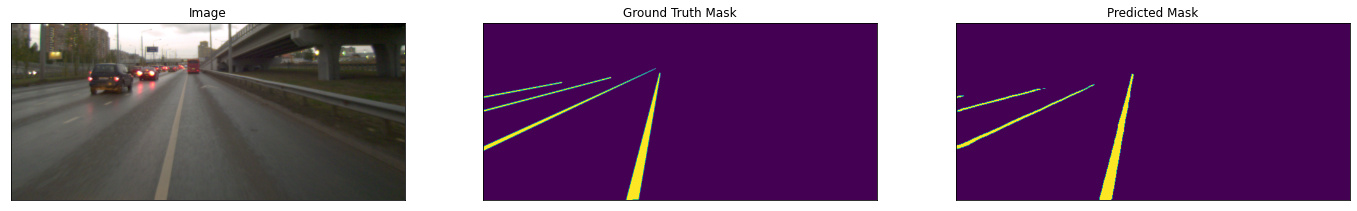

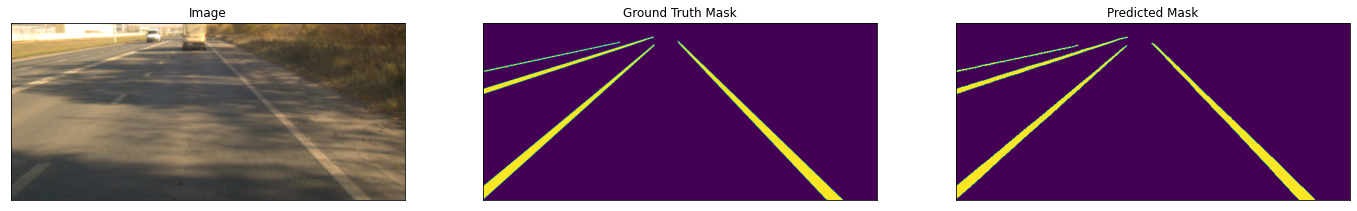

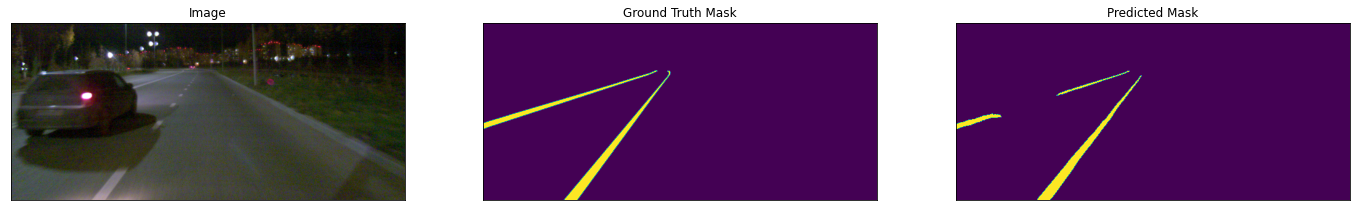

In [55]:
for i in range(20):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )